# Learn to rank on top of Azure Cognitive Search

This notebook showcases how to train an L2 ranker, using a [Learn to rank](https://en.wikipedia.org/wiki/Learning_to_rank) approach, to be run on top of Azure Cognitive Search. 

Through this experiment, we are going to:
1. Use Azure Cognitive Search's new feature computation capability to extract text-based similarity features that describe query-to-document relationships
2. Do additional feature engineering to enhance our dataset further 
3. Train a model using [XGBOOST](https://xgboost.readthedocs.io/en/latest/)
4. Evaluate the ranking produced by the trained model against the base Azure Cognitive Search ranking using the [NDCG metric](https://en.wikipedia.org/wiki/Discounted_cumulative_gain#Normalized_DCG).

In [1]:
%load_ext autoreload
%autoreload 2
# %load_ext memory_profiler
import sys
import os
import json
import warnings
warnings.filterwarnings(action='once')

from pathlib import Path
from pprint import pprint

import numpy as np
import requests

import azs_helpers.l2r_helper as azs

from azs_helpers.azure_search_client import azure_search_client as azs_client 
from azs_helpers.azs_msft_docs import azs_msft_docs as azs_docs

### Experiment setup

This experiment uses a dataset containing **7102 articles** from the **docs.microsoft.com** website. Each article contains a title, body, description, list of api names and a url path. Articles were augmented using the [key phrase extraction cognitive skill](https://docs.microsoft.com/en-us/azure/search/cognitive-search-skill-keyphrases) as well as with popular search terms that led to those articles. Additionally, we augmented the articles with easy to compute metadata that will be leveraged when training, such as the number of sections and tables in each article, as well as the normalized page views count.

You can find the full index definition : `azs_helpers\index_schema\docs-multilingual-20200217.json`

```json
{
  "name": "docs-multilingual-20200217",
  "fields": [
    {
      "name": "id",
      "type": "Edm.String",
      "facetable": true,
        ...
    },
    ...
  ]
}
```


The experiment also relies on a labeled training set containing over 900 unique queries evaluated against various articles. We refer to this data as the "judgment" list, which will be used as the ground truth when evaluating ranking. Each query is evaluated against 1 to 10 different documents, and for each, provides a "grade" representing how relevant that specific document is to that query. A value of 10 indicates high relevance, while a value of 1 indicates lower relevance.

The judgement list can be found here: `PATH_TO_JUDGEMENT_LIST.CSV`

#### Configuration
Details and secrets about your search service should be added to a 'config.json' file of this format:

```json
{
   "service_name": "YOUR_SERVICE_NAME",
   "endpoint": "https://YOUR_SERVICE_NAME.search.windows.net",
   "api_version": "2019-05-06-preview",
   "api_key": "YOUR_API_KEY",
   "index_name": "rankingindex-msft-docs"
}
```   

The 'config.json' file should be placed in the `config` folder within the repository. If you prefer, you can instead uncomment & fill in the cell below, and it'll generate a service config for you.

In [2]:
# Azure search service configuration. You can uncomment the code here 
# and fill in the details if you prefer.

# service_config = {
#     "service_name": <Your Azure Search Service Name>,
#     "endpoint": <YOUR ENDPOINT HERE>,
#     "api_version": "2019-05-06-preview",
#     "api_key": <YOUR API KEY HERE>,
#     "index_name": "docs-multilingual-20200217"
# }

# service_config_root = Path.cwd() / 'config'
# service_config_root.mkdir(parents=True, exist_ok=True)

# service_config_path = service_config_root / 'config.json'
# with open(service_config_path, 'w') as f:
#     json.dump(service_config, f)

In [3]:
import pickle

local_config = {
    "dataset_seed": 42,
    "verbose": False,
    "reindex": False,
    "min_document_count": 7102,
    # Documents path is hardcoded, please change this to your local dir.
    "local_documents_directory_path" : Path("D:/ranking/doc/extracted_ndcg_light"),
    "judgement_file_path": Path.cwd() / 'data' / 'raw' / 'msft_docs_labels.csv',
    "service_metadata_config_path": Path.cwd() / 'config' / 'config.json'
}

local_config_path = Path.cwd() / 'config' / 'local_config.pkl'

with open(local_config_path, 'wb') as f:
    pickle.dump(local_config, f, protocol=pickle.HIGHEST_PROTOCOL)

azs_service = azs_client.from_json(local_config['service_metadata_config_path'])
msft_docs = azs_docs(local_config['judgement_file_path'])

## Service preparation
The following section is meant to setup an index with the required data to run the experiment. 

In [4]:
if not azs_service.index_exist():
    print(f"Index {azs_service.index_name} does not exist in service. Creating.")
    index = msft_docs.create_index(azs_service, schema_file="docs-multilingual-20200217.json")
else:
    print(f"Index {azs_service.index_name} already exists. Skipping creation.")
    
doc_count = azs_service.index_documents_count()
if doc_count < local_config["min_document_count"]: 
    print(f"Index {azs_service.index_name} contains only {doc_count} out of {local_config['min_document_count']} documents. Uploading documents.")
    docs = msft_docs.get_documents_from_local_folder(local_config["local_documents_directory_path"])
    azs_service.upload_documents(docs, 100)
else:
    print(f"Index {azs_service.index_name} contains all {doc_count} documents. Skipping uploading.")

/home/homeuser/anaconda3/envs/azs-l2r/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'azszorl.eastus.cloudapp.azure.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


Succesfully connected to search service 'azslearntorank'
Index docs-multilingual-20200217 already exists. Skipping creation.
Index docs-multilingual-20200217 contains all 7102 documents. Skipping uploading.


### Extracting features from search service

The following functions are designed to efficiently use the Azure Search service to extract document-query features.

1. We filter each queries to only consider the documents we want to judge. This is achieved by adding a **"filter"** clause to our search query which will restrict the results to the group of documents contained in the group of documents we have judgment values for.
2. We set **"featuresMode"** to "enabled". This will tell the search service to return additional features with the results, including per-field similarity scores.
3. We use the **"select"** clause to only return the url of each documents, as well as a few non-text based fields that could potentially be used as features. This will greatly reduce the amount of data that needs to be transfered between the server and the client.
4. We use the **"searchFields"** parameter to select which text-based fields we want to include in the search process. Those fields will be the only ones for which the service will extract text-based features from (such as per-field similarity).

The expect response to this query will have the following format:

```json
    "value": [
     {
        "@search.score": 5.1958685,
        "@search.features": {
            "description_en_us": {
                "uniqueTokenMatches": 1.0,
                "similarityScore": 0.29541412
            },
            "body_en_us": {
                "uniqueTokenMatches": 3.0,
                "similarityScore": 0.36644348400000004
            },
            "keyPhrases_en_us": {
                "uniqueTokenMatches": 3.0,
                "similarityScore": 0.35014877
            },
            "title_en_us": {
                "uniqueTokenMatches": 3.0,
                "similarityScore": 1.75451557
            },
            "urlPath": {
                "uniqueTokenMatches": 2.0,
                "similarityScore": 1.07175103
            },
            "searchTerms": {
                "uniqueTokenMatches": 3.0,
                "similarityScore": 1.3575956200000001
            }
        },
        "normalized_pageview": null,
        "tableCount": 0,
        "sectionCount": 7,
        "url_en_us": "https://docs.microsoft.com/en-us/azure/search/"
    }]
```

In [5]:
import json
import pandas as pd

def get_search_results_from_service(service, query, urls_filter):
    search_request_body = {
        "search": azs.escape_query(query),
        "featuresMode": "enabled",
        "select": "title_en_us, url_en_us, sectionCount, tableCount, normalized_pageview", 
        "searchFields": "body_en_us,description_en_us,title_en_us,apiNames,urlPath,searchTerms, keyPhrases_en_us",
        "scoringStatistics": "global",
        "sessionId" : "my_session",
        "top" : 20
    }
    if len(urls_filter) > 0:
        search_request_body["filter"] = " or ".join(f"url_en_us eq '{url}'" for url in urls_filter)

    return service.search(search_request_body)

def get_features_from_service(service, query, group):
    urls = group['url'].values.tolist()
    
    search_results = get_search_results_from_service(service, query, urls)

    # this will flatten the search json response into a panda dataframe
    azs_features = pd.json_normalize(search_results)
    
    # we add the data extracted from azure search to our labeled data by merging them on the "url" field
    merged_results = group.join(azs_features.set_index('url_en_us'), on='url')
    
    # some of the labeled documents in our dataset did not match any documents in the Azure Search instance,
    # we will remove them from our data by dropping any row that did not produce a search score
    return merged_results.dropna(subset=['@search.score'])

### Make parallel calls to the Azure Search service to extract features

To extract all the features from our dataset, we start by grouping the judgment list by query. This will provide us with a list of judged documents for each query. Each call to the Azure Cognitive Search service will use the query from the group,  with filters to make sure we only return the documents from the group. In this dataset, we can expect aproximately 900 queries.

To quickly execute those queries, we setup a thread pool executor which will run the queries in parallel. The level of parallelism can be changed to accomodate different search service capacity.

In [6]:
import concurrent
import datetime
from itertools import chain

query_groups = msft_docs.judgements.groupby('query')

print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

executor = concurrent.futures.ThreadPoolExecutor(30)
futures = [executor.submit(get_features_from_service, azs_service, query, group) for (query, group) in query_groups]
concurrent.futures.wait(futures)

print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

all_features = pd.concat([future.result() for future in futures if future], sort=False).fillna(0)

2020-04-21 19:49:32
2020-04-21 19:50:02


## Visualize our Dataset

Now that the data has finished downloading, let's load our data from the last section in and visualize it! Pay attention to a few things in particular:

- The **grade** column represents the ground truth rating for this document, and it is an [ordinal variable](https://en.wikipedia.org/wiki/Ordinal_data) ranging from **1 ~ 10**, from least relevant to most relevant. A grade of '10' means that the document is most relevant, while a grade of '1' means that the document is least relevant.
- **title_en_us** is the English-language title of an article on Microsoft Docs.
- **query** is the search query that led to this document
- All features that begin with an "@" character are returned from the Features API, and will be used extensively by the trained model.
- Some queries have less than 10 documents. We'll have to keep this fact in mind when preparing our data.

In [7]:
print(f"Number of unique queries: {len(all_features.groupby('query'))}")
print(f"Number of documents: {len(all_features)}")
print(f"Number of features: {len(all_features.columns)}")

all_features

Number of unique queries: 981
Number of documents: 8973
Number of features: 26


,query,url,grade,@search.score,normalized_pageview,tableCount,sectionCount,title_en_us,@search.features.body_en_us.uniqueTokenMatches,@search.features.body_en_us.similarityScore,...,@search.features.keyPhrases_en_us.termFrequency,@search.features.title_en_us.uniqueTokenMatches,@search.features.title_en_us.similarityScore,@search.features.title_en_us.termFrequency,@search.features.searchTerms.uniqueTokenMatches,@search.features.searchTerms.similarityScore,@search.features.searchTerms.termFrequency,@search.features.urlPath.uniqueTokenMatches,@search.features.urlPath.similarityScore,@search.features.urlPath.termFrequency
4130,$,https://docs.microsoft.com/en-us/powershell/mo...,10,0.101192,222.160000,1.0,13.0,about_Variables - PowerShell,1.0,0.101192,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
4132,$,https://docs.microsoft.com/en-us/windows/win32...,8,0.155940,1.440000,0.0,0.0,Creating a New Computer Account - Win32 apps,1.0,0.155940,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
4134,$,https://docs.microsoft.com/en-us/windows-hardw...,6,0.043148,3.600000,1.0,2.0,Pseudo-Register Syntax - Windows drivers,1.0,0.043148,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
4136,$,https://docs.microsoft.com/en-us/cpp/build/ref...,4,0.233910,2.680000,0.0,2.0,Special Characters in a Makefile,1.0,0.233910,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
4137,$,https://docs.microsoft.com/en-us/windows-hardw...,3,0.090593,2.460000,0.0,2.0,Symbol Syntax and Symbol Matching - Windows dr...,1.0,0.090593,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1965,zoom,https://docs.microsoft.com/en-us/office/vba/ap...,5,3.183052,0.276596,0.0,3.0,Window.Zoom property (Visio),1.0,0.339155,...,2.0,1.0,1.376789,1.0,0.0,0.000000,0.0,1.0,1.032592,1.0
1966,zoom,https://docs.microsoft.com/en-us/azure/active-...,4,5.304070,14.320000,0.0,9.0,Tutorial: Azure Active Directory single sign-o...,1.0,0.306429,...,11.0,1.0,0.860493,1.0,1.0,1.742096,3.0,1.0,1.032592,1.0
1967,zoom,https://docs.microsoft.com/en-us/dotnet/api/sy...,3,4.034551,0.460000,1.0,5.0,FlowDocumentReader.Zoom Property (System.Windo...,1.0,0.482078,...,4.0,1.0,1.032592,1.0,0.0,0.000000,0.0,1.0,1.032592,1.0
1968,zoom,https://docs.microsoft.com/en-us/office/vba/ap...,2,2.886207,8.640000,0.0,3.0,PageSetup.Zoom property (Excel),1.0,0.169577,...,1.0,1.0,1.376789,1.0,0.0,0.000000,0.0,1.0,1.032592,1.0


### Feature engineering

In this section, we will apply additional domain knowledge to add a few features to our model. For example, we are going to add the title length, in words and in characters.

We are also going to drop columns of our dataset that we won't be using for the training process, such as raw url, title and query text. 

In [8]:
def customize_features(features):
    # adding a query_id column will help us group the data per query later in training
    if 'query_id' not in features:
        features['query_id'] = features.groupby('query').ngroup()
    
    if ('title_en_us' in features):
        features['title_en_us'] = features['title_en_us'].map(lambda title: str(title))
        features['title_length_in_words'] = features['title_en_us'].map(lambda title: len(title.split()))
        features['title_length_in_chars'] = features['title_en_us'].map(lambda title: len(title))

    # Discard the columns that we no longer need
    features = features.drop(['query', 'url', 'title_en_us'], axis=1, errors='ignore')
    return features

all_features = customize_features(all_features)
print("All features collected:")
print(all_features.columns.values)

all_features[['title_length_in_words', 'title_length_in_chars']]

All features collected:
['grade' '@search.score' 'normalized_pageview' 'tableCount' 'sectionCount'
 '@search.features.body_en_us.uniqueTokenMatches'
 '@search.features.body_en_us.similarityScore'
 '@search.features.body_en_us.termFrequency'
 '@search.features.description_en_us.uniqueTokenMatches'
 '@search.features.description_en_us.similarityScore'
 '@search.features.description_en_us.termFrequency'
 '@search.features.keyPhrases_en_us.uniqueTokenMatches'
 '@search.features.keyPhrases_en_us.similarityScore'
 '@search.features.keyPhrases_en_us.termFrequency'
 '@search.features.title_en_us.uniqueTokenMatches'
 '@search.features.title_en_us.similarityScore'
 '@search.features.title_en_us.termFrequency'
 '@search.features.searchTerms.uniqueTokenMatches'
 '@search.features.searchTerms.similarityScore'
 '@search.features.searchTerms.termFrequency'
 '@search.features.urlPath.uniqueTokenMatches'
 '@search.features.urlPath.similarityScore'
 '@search.features.urlPath.termFrequency' 'query_id'
 '

,title_length_in_words,title_length_in_chars
4130,3,28
4132,8,44
4134,5,40
4136,5,32
4137,8,51
...,...,...
1965,3,28
1966,10,75
1967,3,58
1968,3,31


### Visualize Azure Cognitive Search NDCG

[**Normalized Discounted Cumulative Gain (NDCG)**](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Discounted_cumulative_gain) is a common metric used to evaluate search ranking systems.  Using `@search.score` returned from the service, we can calculate and visualize Azure Search's NDCG. This will be the baseline to beat with our ranking model.

- `NDCG@K` denotes the NDCG for lists of K length. For example:
    - `NDCG@1` denotes calculating NDCG for a list containing only the top result in a search query
    - `NDCG@5` would refer to the NDCG for a list containing the top 5 results

,baseline
1,0.692539
2,0.715180
3,0.727685
4,0.745287
5,0.762492
6,0.783064
7,0.805746
8,0.829268
9,0.854059
10,0.872828


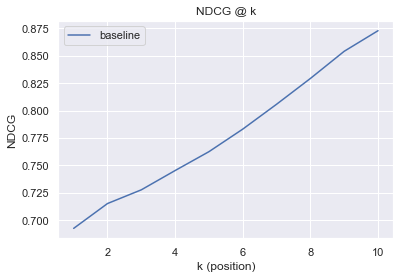

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

query_groups_with_azs_ranking = all_features.sort_values(['@search.score'], ascending=False).groupby('query_id')
ndcg_inputs = [[doc['grade'] for _, doc in group.iterrows()] for query_id, group in query_groups_with_azs_ranking]
original_ndcg = azs.evaluate_ndcg(k_start=1, k_end=10, baseline=ndcg_inputs, plot=True)

## Feature Normalization

Similarity scores are computed to be compared within the context of a single search query, where all documents are evaluated against the same search terms. The range of those scores fluctuates depending on what terms are being searched (for example, common terms often yield to lower similarity scores, since their document frenquency is higher).

To address this problem, we are going to normalize most of our features using the [minmax_scale](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.minmax_scale.html) scaler, which will be applied at the query level group, so that all documents associated with a particular query will have their feature values scaled from 0 to 1.

For features with outlier values, such as `normalized_pageview`, we will use the [QuantileTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html).


In [10]:
from sklearn.preprocessing import minmax_scale, QuantileTransformer

def normalize_features(features):
    query_groups = features.groupby('query_id')

    for feature in features.columns:
        if feature not in['normalized_pageview', 'grade', 'query_id'] and features.dtypes[feature] in [float, int]:
            features[feature] = query_groups[feature].transform(lambda x: minmax_scale(x.astype(float)))
    
    if 'normalized_pageview' in features.columns:
        features['normalized_pageview'] = query_groups['normalized_pageview'].transform(
            lambda x: np.concatenate(
                QuantileTransformer(n_quantiles=min(len(x), 4)).fit_transform(x.values.reshape(-1,1))
            )
        )
    
    return features
    
# %memit df = normalize_features(all_features)
df = normalize_features(all_features)
df.head(5)

,grade,@search.score,normalized_pageview,tableCount,sectionCount,@search.features.body_en_us.uniqueTokenMatches,@search.features.body_en_us.similarityScore,@search.features.body_en_us.termFrequency,@search.features.description_en_us.uniqueTokenMatches,@search.features.description_en_us.similarityScore,...,@search.features.title_en_us.termFrequency,@search.features.searchTerms.uniqueTokenMatches,@search.features.searchTerms.similarityScore,@search.features.searchTerms.termFrequency,@search.features.urlPath.uniqueTokenMatches,@search.features.urlPath.similarityScore,@search.features.urlPath.termFrequency,query_id,title_length_in_words,title_length_in_chars
4130,10,0.304274,1.000000,0.333333,1.000000,0.0,0.304274,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.285714,0.488889
4132,8,0.591270,0.000000,0.000000,0.000000,0.0,0.591270,0.4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.000000,0.844444
4134,6,0.000000,0.352170,0.333333,0.153846,0.0,0.000000,0.1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.571429,0.755556
4136,4,1.000000,0.333333,0.000000,0.153846,0.0,1.000000,0.4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.571429,0.577778
4137,3,0.248711,0.274194,0.000000,0.153846,0.0,0.248711,0.2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.000000,1.000000


### Serialize Data for the Next Step

We'll be running experiments in Part 2. Stay tuned! For now, run the code below to serialize the features.

In [11]:
interim_data_dir = Path.cwd() / 'data' / 'interim'
interim_data_dir.mkdir(parents=True, exist_ok=True)

df.to_pickle(interim_data_dir / 'normalized_features.pkl')